# ViClip Model

In [ ]:
!pip install einops
!pip install ftfy
!pip install timm
!pip install pyarrow

In [ ]:
import os
import json

from typing import List, Dict, Optional, Union
import re

import pandas as pd
import torch
import cv2
import ast
import numpy as np
from tqdm import tqdm
from viclip import get_viclip, retrieve_text

In [58]:
import os
import json

# Путь до твоего видео
video_id = "iOjmy8zkDGQ"  # замени на своё
video_path = f"/workspace/data/Video-MME/output/{video_id}/"

# Считываем кадры
import cv2
from viclip import _frame_from_video
frame_paths = sorted([os.path.join(video_path, "frames", f) for f in os.listdir(os.path.join(video_path, "frames")) if f.endswith(".jpg") or f.endswith(".png")])
frames = [cv2.imread(p) for p in frame_paths[:32]]  # можно выбрать сколько угодно кадров

# Считываем субтитры
with open(os.path.join(video_path, "subtitles.txt")) as f:
    subtitles = [line.strip() for line in f if line.strip()]

# Проверим
print(f"🔹 Loaded {len(frames)} frames and {len(subtitles)} subtitles")


🔹 Loaded 16 frames and 16 subtitles


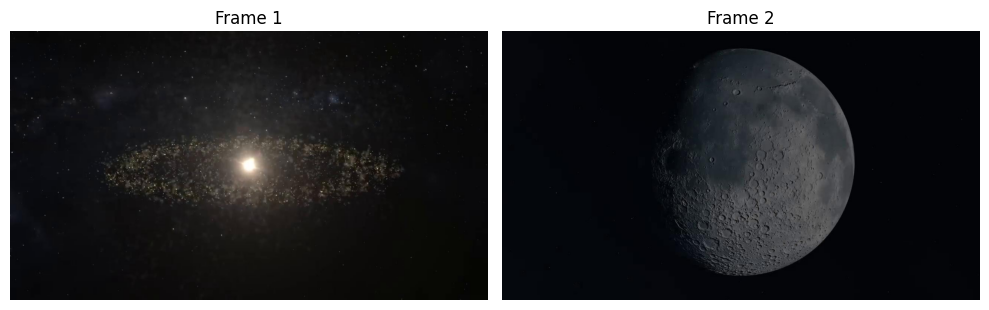

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))  # Преобразование из BGR в RGB
    plt.axis('off')
    plt.title(f"Frame {i+1}")
plt.tight_layout()
plt.show()

In [34]:
from viclip import retrieve_text, get_viclip

models = get_viclip(size='l')
clip = models['viclip'].cuda()

# zero-shot
predictions, probs = retrieve_text(frames, subtitles, models=models)

for i, (t, p) in enumerate(zip(predictions, probs)):
    print(f"{i+1}. {t} ({p:.3f})")


1. 252 million years ago ancient life on (0.431)
2. tubes estimated to be 4.28 billion years (0.398)
3. permian period that began approximately (0.100)
4. earth's surface this is (0.027)
5. airspace with pterosaurs flying reptiles (0.019)


In [ ]:
import pandas as pd

qa_path = "/workspace/data/Video-MME/videomme/test-00000-of-00001.parquet"
qa_df = pd.read_parquet(qa_path)

video_id = "fFjv93ACGo8"
qa_sample = qa_df[qa_df["videoID"] == video_id]

qa_sample.head()

In [56]:
from viclip import retrieve_text

# Запускаем ViCLIP zero-shot c корректным topk
predictions, probs = retrieve_text(frames, options, models=models, topk=len(options))

# Выводим результат
for i, (t, p) in enumerate(zip(predictions, probs)):
    print(f"{i+1}. {t} ({p:.3f})")

print(" Правильный ответ:", correct_answer)
print(" ViCLIP предсказал:", predictions[0])


1. A. How does the heroine do fitness exercises and gain muscle every day. (0.980)
2. B. The heroine's daily eating and shopping routine. (0.013)
3. C. The home life of the heroine and her boyfriend. (0.006)
4. D. None of the above. (0.001)
 Правильный ответ: A
 ViCLIP предсказал: A. How does the heroine do fitness exercises and gain muscle every day.


In [47]:
import os
import json
import pandas as pd
import torch
import cv2
from tqdm import tqdm
from viclip import get_viclip, retrieve_text
import numpy as np

models = get_viclip(size='l')
video_root = "/workspace/data/Video-MME/output"
qa_path = "/workspace/data/Video-MME/videomme/test-00000-of-00001.parquet"
qa_df = pd.read_parquet(qa_path)

clip = models['viclip'].cuda()

# Списки для обоих файлов
all_predictions = []
grouped_output = []

video_ids = qa_df["videoID"].unique()

for video_id in tqdm(video_ids):
    video_path = os.path.join(video_root, video_id)
    frames_path = os.path.join(video_path, "frames")
    subs_path = os.path.join(video_path, "subtitles.txt")

    if not os.path.exists(frames_path) or not os.path.exists(subs_path):
        continue

    frame_paths = sorted([
        os.path.join(frames_path, f) for f in os.listdir(frames_path)
        if f.endswith(".jpg") or f.endswith(".png")
    ])
    if len(frame_paths) == 0:
        continue
    frames = [cv2.imread(p) for p in frame_paths[:32]]

    with open(subs_path) as f:
        subtitles = [line.strip() for line in f if line.strip()]
    subtitle_block = "\n".join(subtitles)

    video_df = qa_df[qa_df["videoID"] == video_id]
    questions_block = []

    for _, row in video_df.iterrows():
        qid = row['question_id']
        question = row['question']
        answer = row['answer']

        # Обработка options
        if isinstance(row['options'], str):
            try:
                import ast
                options = ast.literal_eval(row['options'].replace('\x00', ''))
            except Exception:
                options = ["A", "B", "C", "D"]
        else:
            options = list(row['options'])

        try:
            result, scores = retrieve_text(frames, options, models=models, topk=1)
            predicted_text = result[0]
        except Exception as e:
            predicted_text = "ERROR"

        predicted_letter = None
        for i, opt in enumerate(options):
            if predicted_text.strip() in opt:
                predicted_letter = chr(ord("A") + i)
                break
        if predicted_letter is None:
            predicted_letter = "UNKNOWN"

        q_data = {
            "question_id": qid,
            "answer": answer,
            "response": predicted_text
        }

        # Добавляем в оба списка
        questions_block.append(q_data)

        all_predictions.append({
            "video_id": video_id,
            **q_data
        })

    grouped_output.append({
        "video_id": video_id,
        "questions": questions_block
    })

# Сохраняем оба файла
with open("viclip_predictions.json", "w") as f:
    json.dump(all_predictions, f, indent=2)

with open("viclip_output_test.json", "w") as f:
    json.dump(grouped_output, f, indent=2)

print("✅ Saved viclip_predictions.json and viclip_output_test.json")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [17:33<00:00,  1.17s/it]

✅ Saved viclip_predictions.json and viclip_output_test.json


In [48]:
import json

# Загружаем и печатаем начало viclip_predictions.json
with open("viclip_predictions.json", "r") as f:
    predictions = json.load(f)
    print("📄 viclip_predictions.json (первые 3 строки):")
    for entry in predictions[:3]:
        print(json.dumps(entry, indent=2))

print("\n" + "="*80 + "\n")

📄 viclip_predictions.json (первые 3 строки):
{
  "video_id": "fFjv93ACGo8",
  "question_id": "001-1",
  "answer": "C",
  "response": "A. Apples."
}
{
  "video_id": "fFjv93ACGo8",
  "question_id": "001-2",
  "answer": "A",
  "response": "A. It is a news report that introduces the history behind Christmas decorations."
}
{
  "video_id": "fFjv93ACGo8",
  "question_id": "001-3",
  "answer": "D",
  "response": "B. 4."
}




In [49]:
# Загружаем и печатаем начало viclip_output_test.json
with open("viclip_output_test.json", "r") as f:
    output = json.load(f)
    print("📄 viclip_output_test.json (первые 3 строки):")
    for entry in output[:3]:
        print(json.dumps(entry, indent=2))

📄 viclip_output_test.json (первые 3 строки):
{
  "video_id": "fFjv93ACGo8",
  "questions": [
    {
      "question_id": "001-1",
      "answer": "C",
      "response": "A. Apples."
    },
    {
      "question_id": "001-2",
      "answer": "A",
      "response": "A. It is a news report that introduces the history behind Christmas decorations."
    },
    {
      "question_id": "001-3",
      "answer": "D",
      "response": "B. 4."
    }
  ]
}
{
  "video_id": "N1cdUjctpG8",
  "questions": [
    {
      "question_id": "002-1",
      "answer": "C",
      "response": "D. Sacrificial table."
    },
    {
      "question_id": "002-2",
      "answer": "D",
      "response": "A. Because it's from Ming Dynasty and of specific archaeological significance."
    },
    {
      "question_id": "002-3",
      "answer": "B",
      "response": "C. 5."
    }
  ]
}
{
  "video_id": "HIjX8OPuf-w",
  "questions": [
    {
      "question_id": "003-1",
      "answer": "B",
      "response": "B. 4."
    },
  

In [53]:
video_root = "/workspace/data/Video-MME/output"
qa_path = "/workspace/data/Video-MME/videomme/test-00000-of-00001.parquet"

models = get_viclip(size='l')
clip = models['viclip'].cuda()

# аннотации
qa_df = pd.read_parquet(qa_path)
video_ids = qa_df["videoID"].unique()

final_output = []

for video_id in tqdm(video_ids):
    video_path = os.path.join(video_root, video_id)
    frames_dir = os.path.join(video_path, "frames")
    subs_path = os.path.join(video_path, "subtitles.txt")

    if not os.path.exists(frames_dir) or not os.path.exists(subs_path):
        continue

    frame_paths = sorted([
        os.path.join(frames_dir, f) for f in os.listdir(frames_dir)
        if f.endswith(".jpg") or f.endswith(".png")
    ])
    if len(frame_paths) == 0:
        continue
    frames = [cv2.imread(p) for p in frame_paths[:32]]

    with open(subs_path) as f:
        subtitles = [line.strip() for line in f if line.strip()]
    subtitle_block = "\n".join(subtitles)

    video_df = qa_df[qa_df["videoID"] == video_id]

    # Для заголовков видео
    metadata = video_df.iloc[0]
    video_entry = {
        "video_id": metadata["video_id"],
        "duration": metadata["duration"],
        "domain": metadata["domain"],
        "sub_category": metadata["sub_category"],
        "questions": []
    }

    for _, row in video_df.iterrows():
        try:
            qid = row["question_id"]
            task_type = row["task_type"]
            question = row["question"]
            answer = row["answer"]

            # Опции
            if isinstance(row["options"], (list, tuple, np.ndarray)):
                options = list(row["options"])
            elif isinstance(row["options"], str):
                options = ast.literal_eval(row["options"].replace('\x00', ''))
            else:
                options = ["A", "B", "C", "D"]

            # Инференс
            try:
                result, scores = retrieve_text(frames, options, models=models, topk=1)
                response = result[0]
            except:
                response = "ERROR"

            question_entry = {
                "question_id": qid,
                "task_type": task_type,
                "question": question,
                "options": options,
                "answer": answer,
                "response": response
            }

            video_entry["questions"].append(question_entry)

        except Exception as e:
            print(f"Ошибка на вопросе {row.get('question_id', '??')} в видео {video_id}: {e}")

    final_output.append(video_entry)

# Сохраняем
with open("viclip_output_test.json", "w") as f:
    json.dump(final_output, f, indent=2)

print("✅ Saved viclip_output_test.json в нужном формате")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [17:46<00:00,  1.18s/it]

✅ Saved viclip_output_test.json в нужном формате


In [54]:
CATEGORIES = [
    "Knowledge",
    "Film & Television",
    "Sports Competition",
    "Artistic Performance",
    "Life Record",
    "Multilingual"
]

SUB_CATEGORIES = [
    "Humanity & History",
    "Literature & Art",
    "Biology & Medicine",
    "Finance & Commerce",
    "Astronomy",
    "Geography",
    "Law",
    "Life Tip",
    "Technology",
    "Animation",
    "Movie & TV Show",
    "Documentary",
    "News Report",
    "Esports",
    "Basketball",
    "Football",
    "Athletics",
    "Other Sports",
    "Stage Play",
    "Magic Show",
    "Variety Show",
    "Acrobatics",
    "Handicraft",
    "Food",
    "Fashion",
    "Daily Life",
    "Travel",
    "Pet & Animal",
    "Exercise",
    "Multilingual"
]

TASK_CATEGORIES = [
    "Temporal Perception",
    "Spatial Perception",
    "Attribute Perception",
    "Action Recognition",
    "Object Recognition",
    "OCR Problems",
    "Counting Problem",
    "Temporal Reasoning",
    "Spatial Reasoning",
    "Action Reasoning",
    "Object Reasoning",
    "Information Synopsis",
]

def extract_characters_regex(s):
    s = s.strip()
    answer_prefixes = [
        "The best answer is", "The correct answer is", "The answer is", "The answer",
        "The best option is", "The correct option is", "Best answer:", "Best option:",
        "Answer:", "Option:", "The correct answer", "The correct option",
    ]
    for prefix in answer_prefixes:
        s = s.replace(prefix, "")
    if len(s.split()) > 10 and not re.search("[ABCD]", s):
        return ""
    match = re.search(r"[ABCD]", s)
    return match[0] if match else ""

def eval_your_results(
    your_results_path: str,
    video_types: Union[str, List[str]],
    return_categories_accuracy: bool = True,
    return_sub_categories_accuracy: bool = True,
    return_task_types_accuracy: bool = True,
    save_to: Optional[str] = "viclip_eval_results.json"
):
    with open(your_results_path, 'r') as f:
        your_results = json.load(f)

    if isinstance(video_types, str):
        video_types = video_types.split(",")

    q_type_dict = {}
    v_type_dict = {}
    v_sub_type_dict = {}
    log_lines = []

    for video_type in video_types:
        video_type_results = [v for v in your_results if v["duration"] == video_type]

        q_type_dict[video_type] = {q: {"correct": 0, "answered": 0} for q in TASK_CATEGORIES}
        v_type_dict[video_type] = {c: {"correct": 0, "answered": 0} for c in CATEGORIES}
        v_sub_type_dict[video_type] = {sc: {"correct": 0, "answered": 0} for sc in SUB_CATEGORIES}

        for item in video_type_results:
            category = item["domain"]
            sub_category = item["sub_category"]

            for q in item["questions"]:
                q_type = q["task_type"]
                gt = q["answer"]
                resp = q["response"]
                guess = extract_characters_regex(resp)

                if guess != "":
                    is_correct = guess == gt
                    q_type_dict[video_type][q_type]["answered"] += 1
                    q_type_dict[video_type][q_type]["correct"] += is_correct

                    v_type_dict[video_type][category]["answered"] += 1
                    v_type_dict[video_type][category]["correct"] += is_correct

                    v_sub_type_dict[video_type][sub_category]["answered"] += 1
                    v_sub_type_dict[video_type][sub_category]["correct"] += is_correct

    # Вывод в консоль и в лог
    def format_accuracy(correct, total):
        return f"{100 * correct / total:.1f}%" if total > 0 else "0.0%"

    def log_and_print(line):
        print(line)
        log_lines.append(line)

    for video_type in video_types:
        log_and_print("="*40)
        log_and_print(f"🎞 Evaluation on video type: {video_type}")
        log_and_print("="*40)

        if return_categories_accuracy:
            log_and_print("--- Video Domains ---")
            for v in CATEGORIES:
                c = v_type_dict[video_type][v]
                log_and_print(f"{v}: {format_accuracy(c['correct'], c['answered'])}")

        if return_sub_categories_accuracy:
            log_and_print("--- Subcategories ---")
            for s in SUB_CATEGORIES:
                c = v_sub_type_dict[video_type][s]
                log_and_print(f"{s}: {format_accuracy(c['correct'], c['answered'])}")

        if return_task_types_accuracy:
            log_and_print("--- Task Types ---")
            for t in TASK_CATEGORIES:
                c = q_type_dict[video_type][t]
                log_and_print(f"{t}: {format_accuracy(c['correct'], c['answered'])}")

        total_correct = sum(q["correct"] for q in q_type_dict[video_type].values())
        total_answered = sum(q["answered"] for q in q_type_dict[video_type].values())
        log_and_print(f"✅ Overall Accuracy: {format_accuracy(total_correct, total_answered)}")
        log_and_print("")

    # Save output
    if save_to:
        with open(save_to, "w") as f:
            json.dump({"log": log_lines}, f, indent=2)
        print(f"\n📁 Saved log to {save_to}")

# Пример вызова
eval_your_results(
    your_results_path="viclip_output_test.json",
    video_types=["short"],  # или "short,long"
    return_categories_accuracy=True,
    return_sub_categories_accuracy=True,
    return_task_types_accuracy=True
)

🎞 Evaluation on video type: short
--- Video Domains ---
Knowledge: 38.8%
Film & Television: 42.5%
Sports Competition: 43.3%
Artistic Performance: 52.6%
Life Record: 35.6%
Multilingual: 29.2%
--- Subcategories ---
Humanity & History: 20.8%
Literature & Art: 44.4%
Biology & Medicine: 41.7%
Finance & Commerce: 50.0%
Astronomy: 47.6%
Geography: 29.6%
Law: 45.8%
Life Tip: 40.0%
Technology: 28.6%
Animation: 45.8%
Movie & TV Show: 46.7%
Documentary: 25.0%
News Report: 54.2%
Esports: 55.6%
Basketball: 33.3%
Football: 61.9%
Athletics: 38.1%
Other Sports: 33.3%
Stage Play: 88.9%
Magic Show: 38.9%
Variety Show: 48.1%
Acrobatics: 66.7%
Handicraft: 33.3%
Food: 46.7%
Fashion: 29.2%
Daily Life: 25.9%
Travel: 42.9%
Pet & Animal: 58.3%
Exercise: 29.2%
Multilingual: 29.2%
--- Task Types ---
Temporal Perception: 42.9%
Spatial Perception: 55.6%
Attribute Perception: 34.7%
Action Recognition: 35.8%
Object Recognition: 45.0%
OCR Problems: 40.5%
Counting Problem: 27.3%
Temporal Reasoning: 45.5%
Spatial Reaso